In [1]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer, CLIPTextModelWithProjection
from transformers import AutoProcessor, CLIPVisionModelWithProjection
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from sklearn.manifold import TSNE
import scipy.stats as st 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances

import graph_structure as gs

/home/tiago/anaconda3/envs/graph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pickle_file_path = "../data/embeds_cifar100.pkl"
data = pickle.load(open(pickle_file_path, 'rb'))
image_embeds = data["image_embeds"]
y_real = data["y_real"]
text_embeds = data["text_embeds"]
templates = data["templates"]
texts = data["texts"]
classes = data["classes"]


In [3]:
def class_rep(X, y):
    X_ = []
    y_ = []
    for c in set(list(y)):
        X_.append(np.mean (X[y==c], axis=0))
        y_.append(c)
    return np.array(X_), np.array(y_).reshape( (-1, 1))



In [4]:
# Plot of a real-life case
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
print(X.shape)
dgs = []
labels = []
ks = list(range(1, len(y)))
for i in tqdm(range(len(templates))):
    labels.append(templates[i])
    dg = []
    Z = text_embeds[i::len(templates),:]
    for idx, k in enumerate(ks):
        sg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
        dg.append(sg)
      
    dgs.append(dg)        

(100, 512)


  0%|          | 0/18 [00:00<?, ?it/s]

 44%|████▍     | 8/18 [00:30<00:37,  3.77s/it]


KeyboardInterrupt: 

In [ ]:
M = 100-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

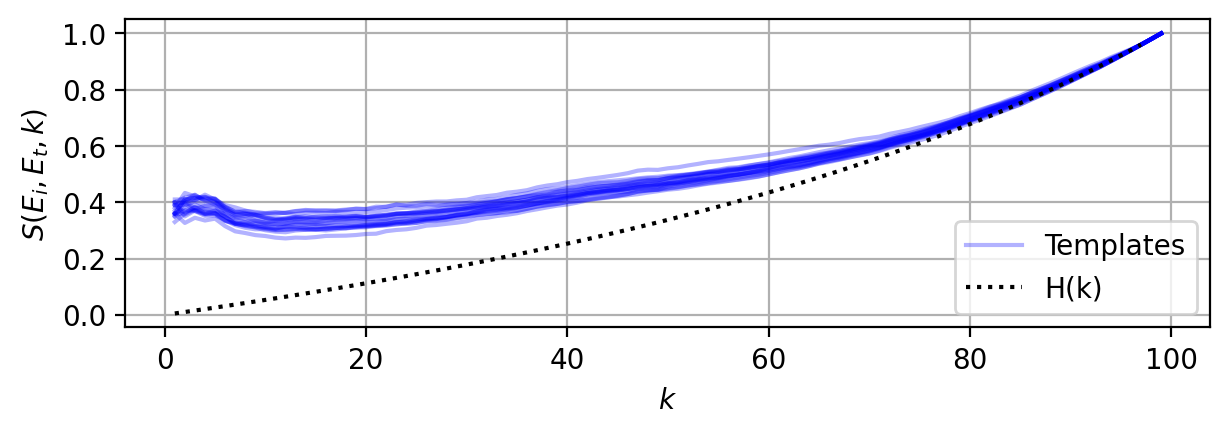

In [ ]:
plt.figure(figsize=(7,2))

plt.plot(ks, np.array(dgs).T[:,0], 'b-', alpha=0.3, label='Templates')
plt.plot(ks, np.array(dgs).T[:,1:], 'b-', alpha=0.3)
#plt.scatter( ks[np.argmax(res)], np.max(res), label='$S_g(A,B)$', c='r')
#plt.title(f'$d$ for different $k$. samples={n_samples}, SNR={np.round(SNR,2)}dB' )
plt.xlabel('$k$')
plt.ylabel('$S(E_i, E_t, k)$')
#plt.legend(ncol=4)
plt.plot(n, js, 'k:', label='H(k)')
plt.legend(loc='lower right')
#plt.xlim([0,5])
#plt.ylim([0, 1])
#plt.semilogx()
#plt.semilogy()
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('s_original_embeddings_k.pdf', bbox_inches='tight')
plt.show()

In [4]:

X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
k = 3
acc = []
jdist = []
for i in range(len(templates)):
    Z = text_embeds[i::len(templates),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    #dg = mean_neighborhoood_distance(X, Z, 5)
    dg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
    jdist.append(dg)

print(acc)
print(jdist)
print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

[0.6448, 0.6384, 0.6354, 0.6457, 0.641, 0.638, 0.6403, 0.6319, 0.6233, 0.6323, 0.6202, 0.6162, 0.6299, 0.6324, 0.6315, 0.6277, 0.6342, 0.5903]
[0.40900000000000003, 0.4260000000000001, 0.408, 0.4210000000000001, 0.41500000000000015, 0.42700000000000016, 0.4160000000000001, 0.4040000000000001, 0.3820000000000001, 0.373, 0.374, 0.3779999999999999, 0.392, 0.36899999999999994, 0.3709999999999999, 0.36900000000000005, 0.38300000000000006, 0.34499999999999986]
PearsonRResult(statistic=0.7774694085414425, pvalue=0.0001463092540786784)
SignificanceResult(statistic=0.762641898864809, pvalue=0.00023296654976518388)


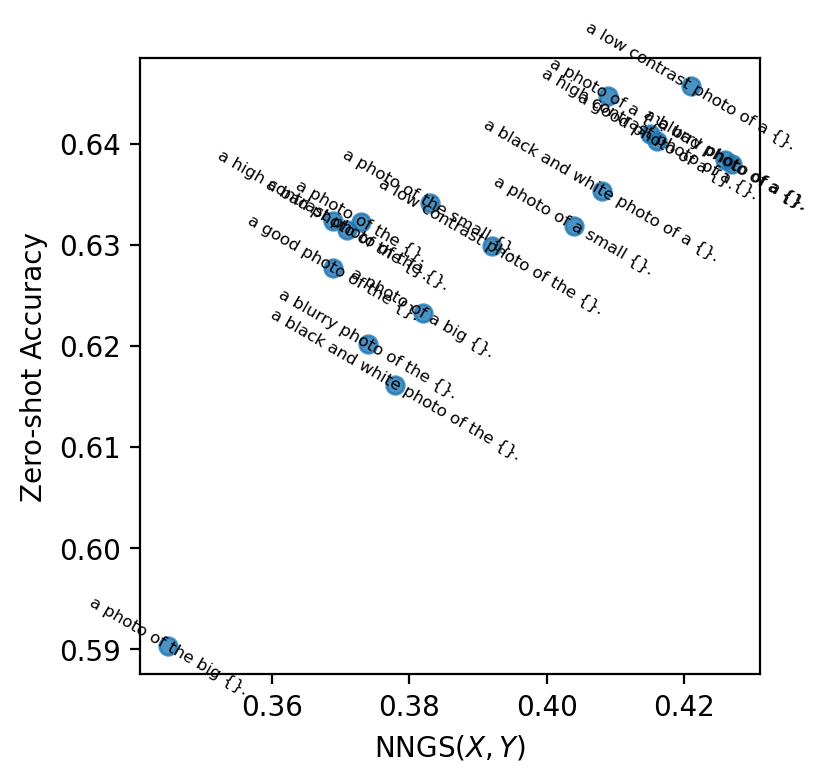

In [5]:
plt.figure(figsize=(4,4))
plt.scatter(jdist, acc, s=40, alpha=0.8)
for i in range(len(templates)):
    plt.text(jdist[i], acc[i], templates[i], fontsize=6, ha='center', va='center', rotation=-30)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
plt.xlabel('$\\text{NNGS}(X,Y)$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg.pdf', bbox_inches='tight')
plt.show()

# With added templates

In [6]:
# templates_ = [
#     'No, Luke. I AM your {}.',
#     'Not a {}.',
#     'The sound of a {}.',
#     'Feel the power of a {}.',
#     'Born to be {}.',
#     'Hasta la vista, {}!',
#     'I am feeling supersonic, give me {} and tonic.',
#     'LOL {} is SO random!',
#     'Perhaps {} could help us save Robin from The Joker.',
#     'The wheels on the {} go round and round.',
#     'We all live in a yellow {}',
#     '{}.',
#     'I like {}',
#     'I cant find the {} here.',
#     'I can find the {} here.',
#     'Most {} are good-looking.',
#     'You are a {}, Harry!',
#     'AND MY {}!',
#     'We must take the {} to Mordor!',
# ]

templates_movies = [
    'Luke. I am your {}.',
    'The sound of a {}.',
    'Feel the power of a {}.',
    'Born to be {}.',
    'I am feeling supersonic, give me {} and tonic.',
    'Stop trying to make {} happen!',
    'Perhaps {} could help us save Robin from The Joker.',
    'The wheels on the {} go round and round.',
    'We all live in a yellow {}',
    'I can find the {} here.',
    '{}, we have a problem.',
    'You cannot handle the {}.',
    'I am the {} of the world.',
    'There is no place like {}.',
    'You are a {}, Harry!',
    'AND MY {}!',
    'We must take the {} to Mordor!',
]

# templates_ = [
#     'This is a {}.',
#     'This is not a {}.'
    
# ]

templates_neg = ['not ' + s for s in templates]

# templates_neg = [
#     'Luke. I am NOT your {}.',
#     'Not the sound of a {}.',
#     'Don\'t feel the power of a {}.',
#     'Not born to be {}.',
#     'I am not feeling supersonic, do not give me {} and tonic.',
#     'LOL {} is SO not random!',
#     'Perhaps {} could not help us save Robin from The Joker.',
#     'The wheels on the {} do not go round and round.',
#     'We do not live in a yellow {}',
#     'Not {}.',
#     'I do not like {}',
#     'I cannot find the {} here.',
#     'Most {} are bad-looking.',
#     'You are not a {}, Harry!',
#     'NOT MY {}!',
#     'We must not take the {} to Mordor!',
# ]

#templates_ = templates_ + templates_neg


texts_ = []
templates_ = templates + templates_neg + templates_movies
for c in classes:    
    for t in templates_:
        texts_.append(t.format(c))



In [7]:
# Get text embeddings
class TextDatasetFromList(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __getitem__(self, index):
        return self.texts[index]

    def __len__(self):
        return len(self.texts)

model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").cuda()
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

dataset = TextDatasetFromList(texts_)
data_loader = DataLoader(dataset, batch_size=64, num_workers=4)
all_embeds = []
for batch in tqdm(data_loader):
    inputs = tokenizer(batch, padding=True, return_tensors="pt")
    inputs = {k: v.cuda() for k, v in inputs.items()}
    outputs = model(**inputs)
    text_embeds = outputs.text_embeds.detach().cpu().numpy()
    all_embeds.append(text_embeds)
text_embeds_ = np.concatenate(all_embeds, axis=0)

/home/tiago/anaconda3/envs/graph/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 83/83 [00:01<00:00, 73.73it/s]


In [ ]:
# Plot of a real-life case
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
print(X.shape)
dgs = []
labels = []
ks = list(range(1, len(y)))
for i in tqdm(range(len(templates_))):
    labels.append(templates_[i])
    dg = []
    Z = text_embeds_[i::len(templates_),:]
    for idx, k in enumerate(ks):
        sg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
        dg.append(sg)
      
    dgs.append(dg)        

(100, 512)


  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [07:29<00:00,  8.48s/it]


In [ ]:
M = 100-1
n=ks
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

/home/tiago/anaconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:654: RuntimeWarning: divide by zero encountered in divide
  g2 /= n * N * (M - N) * m * (M - 2.) * (M - 3.)
/home/tiago/anaconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:658: RuntimeWarning: divide by zero encountered in _hypergeom_skewness
  _boost._hypergeom_skewness(n, N, M),


In [8]:
plt.figure(figsize=(7,2))

labels = ['Positives', 'Negatives', 'Film/Music']
colormap = [(0,0,1,1), (1,0,0,1), (0.3,.7,0.3,1)]
colors = [colormap[0]]*len(templates) + [colormap[1]] * len(templates_neg) + [colormap[2]] * len(templates_movies)

for i in range(len(dgs)):
    if i==0:
        label=labels[0]
    elif i==len(templates)+1:
        label=labels[1]
    elif i==2*len(templates)+1:
        label=labels[2]
    else:
        label = None
    plt.plot(ks, dgs[i], '-', c=colors[i], alpha=.3, label=label)
#plt.scatter( ks[np.argmax(res)], np.max(res), label='$S_g(A,B)$', c='r')
#plt.title(f'$d$ for different $k$. samples={n_samples}, SNR={np.round(SNR,2)}dB' )
plt.xlabel('$k$')
plt.ylabel('$\\text{NNGS}(E_i, E_t, k)$')
#plt.legend(ncol=4)

plt.plot(n, js, 'k:', label='H(k)' )
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 2, 3]  # Ordem desejada para as legendas (nesse caso, trocando a ordem)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
#plt.xlim([0,5])
#plt.ylim([0, 1])
#plt.semilogx()
#plt.semilogy()
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('s_embeddings_k_with_weird.pdf', bbox_inches='tight')
plt.show()

NameError: name 'dgs' is not defined

<Figure size 700x200 with 0 Axes>

In [9]:
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
k = 3
acc = []
jdist = []
for i in range(len(templates_)):
    Z = text_embeds_[i::len(templates_),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    dg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
    jdist.append(dg)

print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

PearsonRResult(statistic=0.9020793443906105, pvalue=2.9960562973911225e-20)
SignificanceResult(statistic=0.9201306293593516, pvalue=2.0717427921128478e-22)


/tmp/ipykernel_93848/893283339.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(jdist[:len(templates)], acc[:len(templates)], s=40, alpha=0.8, c=colormap[0], label=labels[0])
/tmp/ipykernel_93848/893283339.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(jdist[len(templates):len(templates)+len(templates_neg)], acc[len(templates):len(templates)+len(templates_neg)], s=40, alpha=0.8, c=colormap[1],

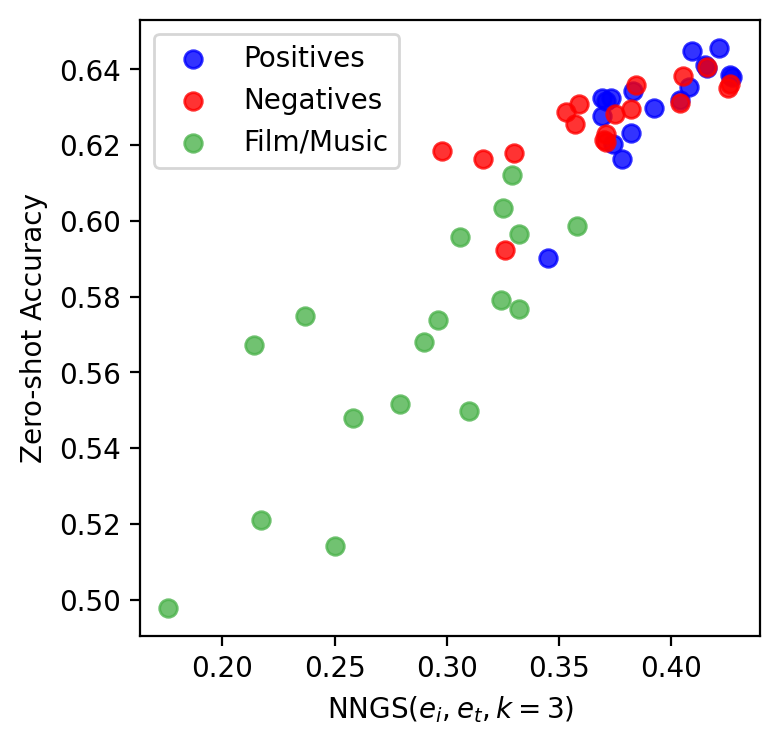

In [11]:
plt.figure(figsize=(4,4))
jdist=np.array(jdist)
acc=np.array(acc)
plt.scatter(jdist[:len(templates)], acc[:len(templates)], s=40, alpha=0.8, c=colormap[0], label=labels[0])
plt.scatter(jdist[len(templates):len(templates)+len(templates_neg)], acc[len(templates):len(templates)+len(templates_neg)], s=40, alpha=0.8, c=colormap[1], label=labels[1])
plt.scatter(jdist[len(templates)+len(templates_neg):], acc[len(templates)+len(templates_neg):], s=40, alpha=0.8, c=colormap[2], label=labels[2])

# for i in range(len(templates_)):
#     plt.text(jdist[i], acc[i], templates_[i], fontsize=4, ha='center', va='center', rotation=-5)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
# for i in range(n_new):
#     plt.arrow(x=jdist[i], y=acc[i], dx=jdist[n_new+i]-jdist[i], dy=acc[n_new+i]-acc[i],
#               length_includes_head=True, width=0.0002, head_width=0.002, head_length=0.003,
#               alpha=0.5)

plt.xlabel(f'NNGS$(e_i,e_t,k={k})$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg_dirty_cifar100_nngs.pdf', bbox_inches='tight')
plt.legend()
plt.show()